In [1]:
import corner
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
data_dir = os.path.abspath(os.path.join(root_dir, '..', 'data'))

In [2]:
random_state = 256
rng = np.random.RandomState(random_state)

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'nearest_1-100-pc.csv'))

In [4]:
phase_space_dimensions = ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity']

galactic_coords = ['l', 'b']

SNR_cut = (np.abs(df.radial_velocity) / df.radial_velocity_error > 10) &\
          (np.abs(df.pmra) / df.pmra_error > 10) &\
          (np.abs(df.pmdec) / df.pmdec_error > 10) &\
          (df.parallax_over_error > 10)

d1 = df[SNR_cut][phase_space_dimensions + galactic_coords].dropna().copy()

In [5]:
np.sum(SNR_cut)

53213

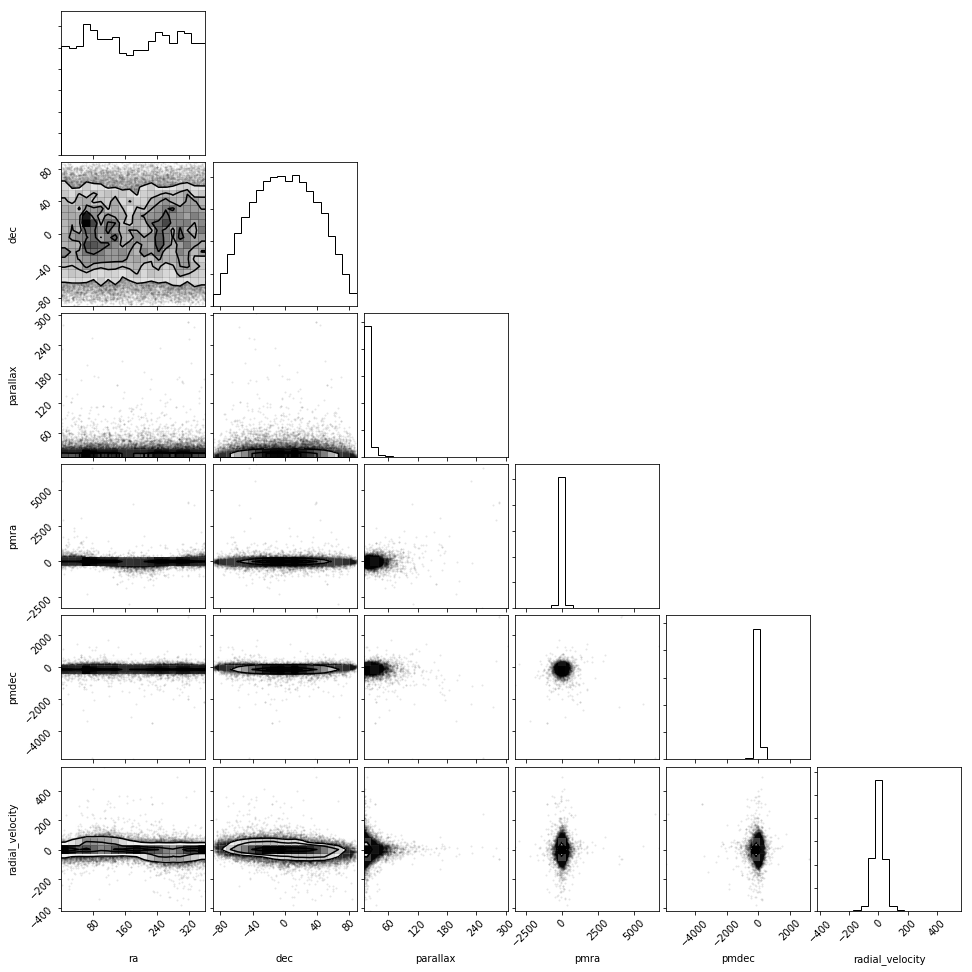

In [6]:
corner.corner(d1[phase_space_dimensions]);

In [7]:
d1.shape

(53213, 8)

## High galactic lattitudes...

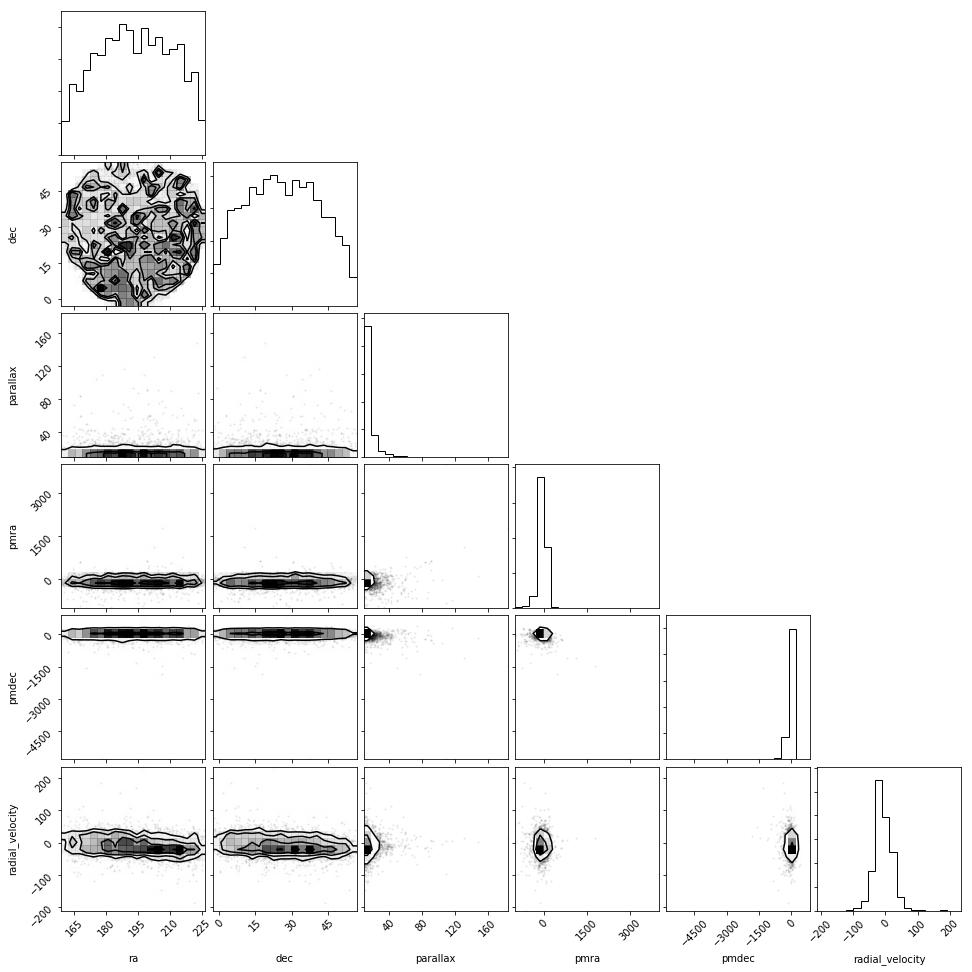

In [8]:
high_lattitude_selection = (d1.b > 60)

hi_lat = d1[high_lattitude_selection].copy()

corner.corner(hi_lat[phase_space_dimensions]);

### Gaussian Mixture Model (GMM)

I have no idea how many clusters to expect, so let's just try a large-ish number. First we need to scale the data though.

In [9]:
hi_lat.shape

(2982, 8)

In [10]:
from sklearn.preprocessing import StandardScaler

# scale these to make mean == 0 and std == 1
scaled_hi_lat = StandardScaler().fit_transform(hi_lat[phase_space_dimensions])

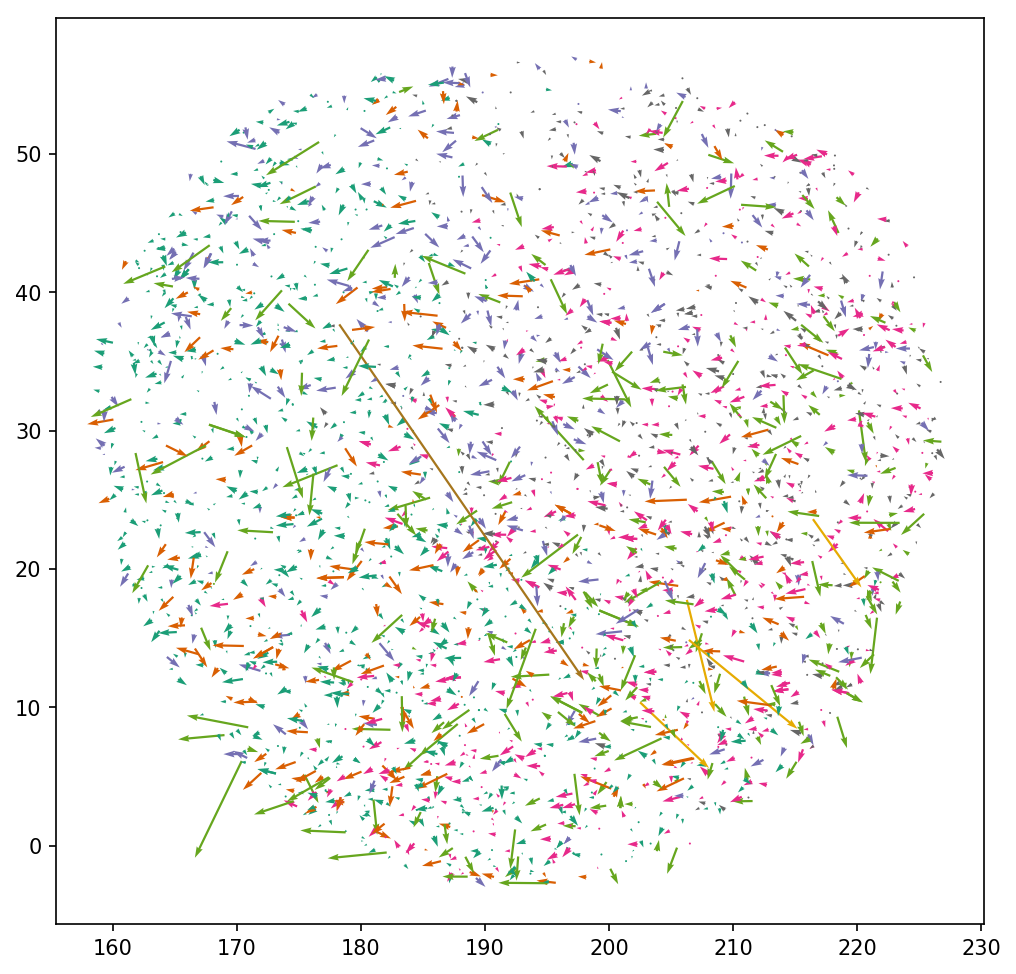

In [11]:
from sklearn.mixture import GaussianMixture

g = GaussianMixture(n_components=10)
g.fit(scaled_hi_lat)
labels = g.predict(scaled_hi_lat)

# visualize the product
fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111)

#ax.scatter(hi_lat.ra, hi_lat.dec, c=labels, cmap=plt.cm.Dark2, s=10)
ax.quiver(hi_lat.ra, hi_lat.dec, hi_lat.pmra, hi_lat.pmdec, color=plt.cm.Dark2(labels / 10.))
    
ax.set_aspect(1. / np.cos(np.deg2rad(hi_lat.dec.mean())))
plt.show()

### Multiply proper motion speeds by distance (angular speed -> physical speed)

Remember that the parallax is an estimator $\varpi~[{\rm mas}] = \frac{1000}{D \rm~[pc]} $. Although we probably should be implementing cuts and should instead be treating all this with a full covariance matrix and Bayesian formalism[...](https://arxiv.org/pdf/1804.09376.pdf) I'll work on that later. 

In [12]:
import astropy.units as u

In [13]:
hi_lat['v_ra'] = np.cos(np.deg2rad(hi_lat.dec)) * (hi_lat.pmra / hi_lat.parallax) * ((u.mas/u.yr) * (u.pc/u.mas)).to(u.km/u.s)
hi_lat['v_dec'] = hi_lat.pmdec / hi_lat.parallax * ((u.mas/u.yr) * (u.pc/u.mas)).to(u.km/u.s)

hi_lat.head()

,ra,dec,parallax,pmra,pmdec,radial_velocity,l,b,v_ra,v_dec
400,176.764672,17.166304,13.186969,-153.897414,-142.720913,13.547234,243.414696,72.099765,-1.090290e+07,-1.058252e+07
844,186.268416,22.928158,13.644398,12.896982,-78.727747,-18.777593,246.617609,82.701096,8.512108e+05,-5.641830e+06
850,191.269506,19.719862,10.267205,4.517143,-71.979225,-9.320125,291.466191,82.449632,4.049590e+05,-6.854906e+06
1058,192.106918,27.783954,10.692628,-29.800991,5.300458,43.525532,168.282476,89.064109,-2.410985e+06,4.847028e+05
1068,192.550942,28.413806,12.173272,-12.629160,-81.579984,-8.332149,134.849498,88.685779,-8.922084e+05,-6.552739e+06


Something appears to be wrong with my tangential velocity units? Regardless they should get normalized.

In [14]:
physical_space = ['ra', 'dec', 'parallax', 'v_ra', 'v_dec', 'radial_velocity']

scaled_hi_lat = StandardScaler().fit_transform(hi_lat[physical_space])

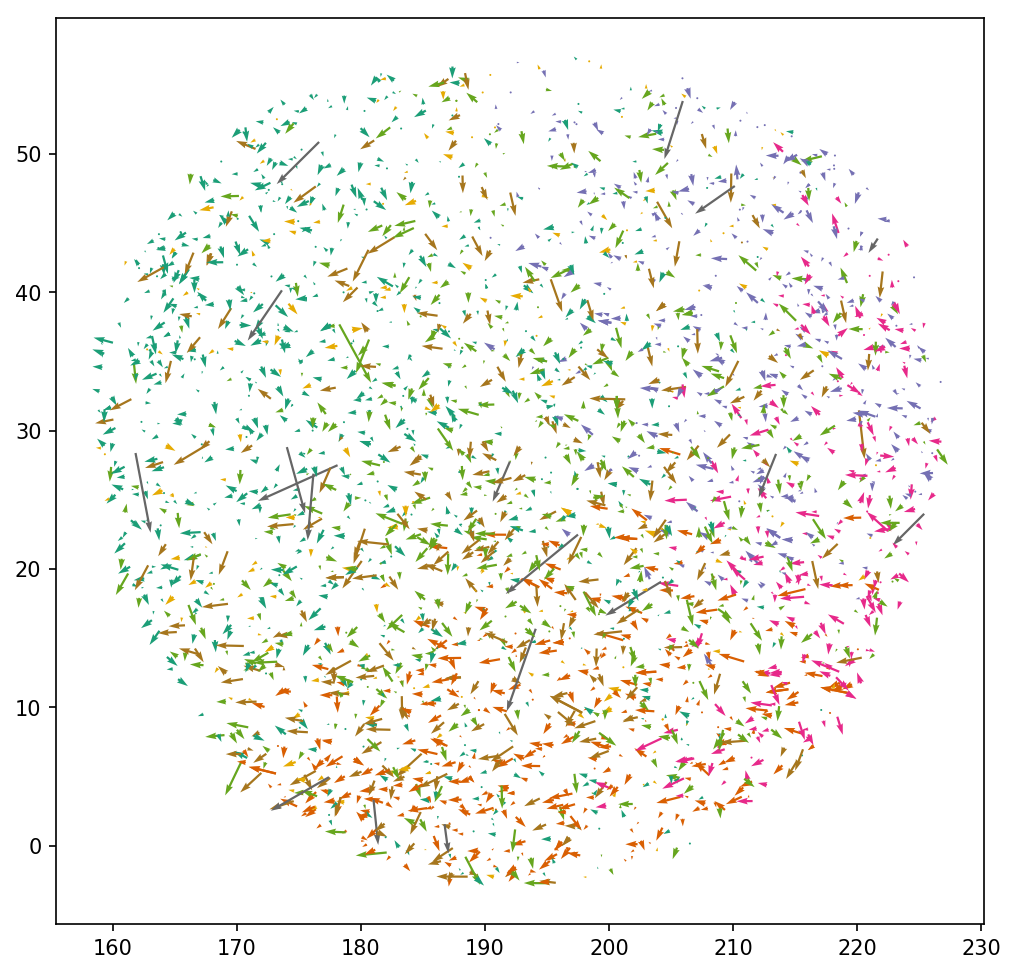

In [15]:
g = GaussianMixture(n_components=10)
g.fit(scaled_hi_lat)
labels = g.predict(scaled_hi_lat)

scaled_hi_lat = StandardScaler().fit_transform(hi_lat[phase_space_dimensions])

fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111)

ax.quiver(hi_lat.ra, hi_lat.dec, hi_lat.v_ra * 1e-5, hi_lat.v_dec * 1e-5, color=plt.cm.Dark2(labels / 10.))
    
ax.set_aspect(1. / np.cos(np.deg2rad(hi_lat.dec.mean())))
plt.show()

### DBSCAN


In [16]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# most of this is lifted straight from sklearn website
min_samples = 5
eps = 0.4
db = DBSCAN(eps=eps, min_samples=min_samples).fit(scaled_hi_lat)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 33


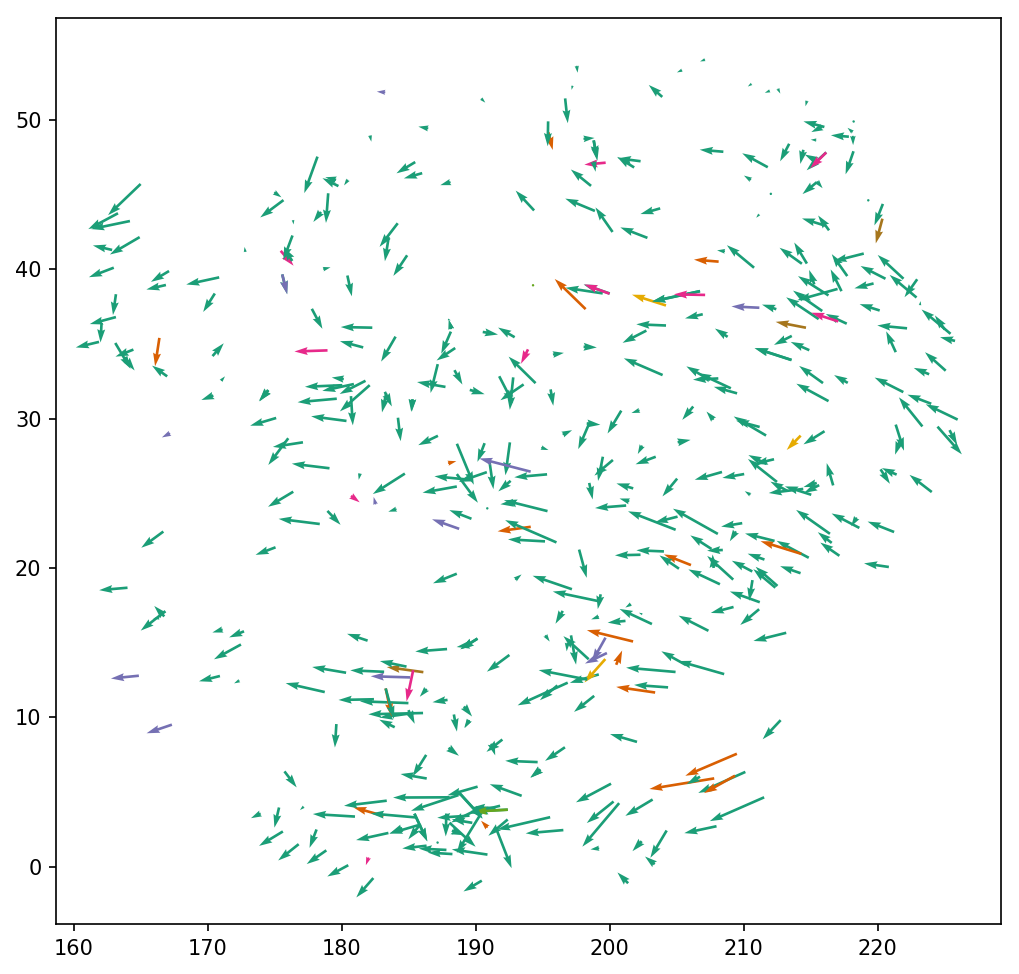

In [17]:
fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111)

q = ax.quiver(hi_lat[labels != -1].ra, hi_lat[labels != -1].dec, 
              hi_lat[labels != -1].v_ra * 1e-5, hi_lat[labels != -1].v_dec * 1e-5, 
              color=plt.cm.Dark2(labels / float(n_clusters_)))
    
ax.set_aspect(1. / np.cos(np.deg2rad(hi_lat.dec.mean())))
plt.show()

## Dimensionality reduction and manifold learning
### ~~t-SNE visualization~~
t-SNE takes way too long. 

## Isomap, PCA
Let's stick with something simpler like isometric mapping

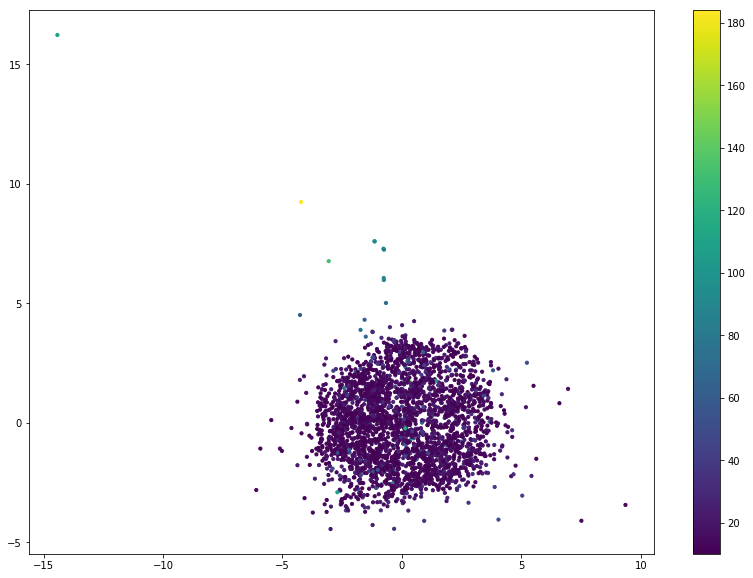

In [18]:
from sklearn.manifold import TSNE, Isomap

n_components = 10
n_neighbors = 5

isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
hi_lat_isomap = isomap.fit_transform(scaled_hi_lat)

plt.figure(figsize=(14, 10))
plt.scatter(hi_lat_isomap[:, 0], hi_lat_isomap[:, 1], 
            c=hi_lat.parallax, cmap=plt.cm.viridis, s=10)
plt.colorbar()

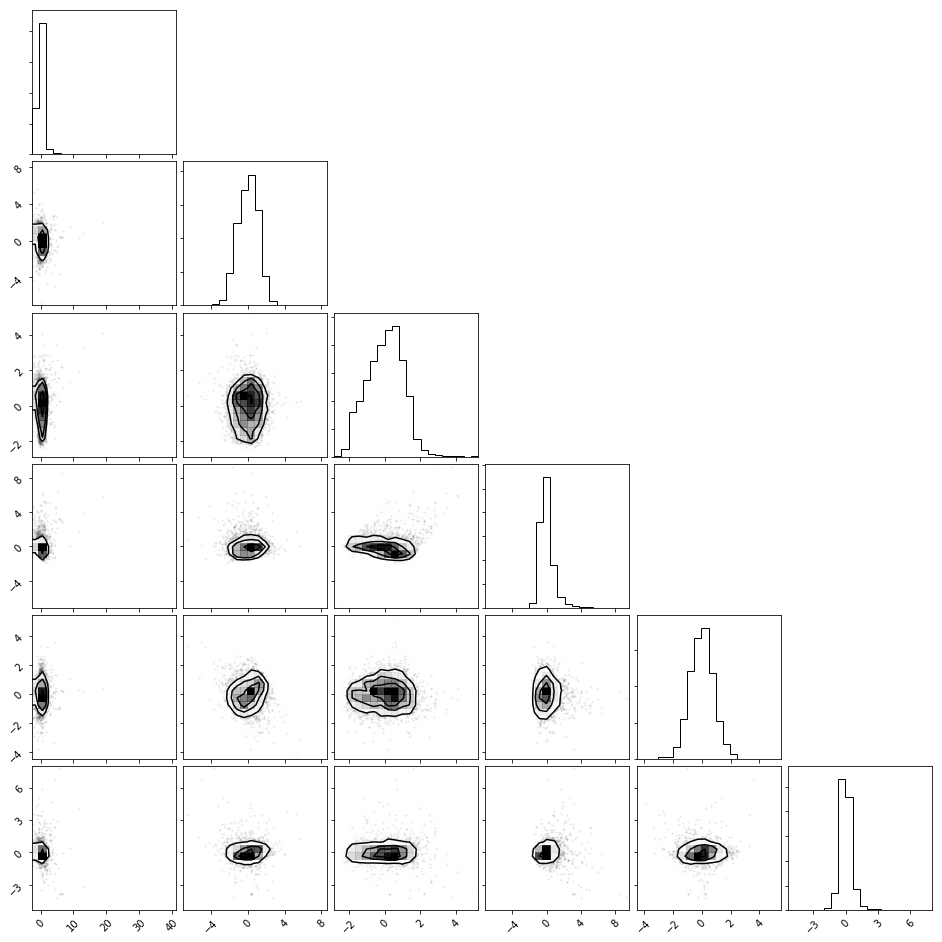

In [19]:
from sklearn.decomposition import PCA

n_components = 6

pca = PCA(n_components=n_components, svd_solver='randomized')
hi_lat_pca = pca.fit_transform(scaled_hi_lat)

corner.corner(hi_lat_pca);

# re-expanding the sample

I wonder if the ~2500 objects I'm looking at are not enough. Let's go back to the big sample of ~50k nearby high SNR sources.

In [20]:
d1['v_ra'] = np.cos(np.deg2rad(d1.dec)) * (d1.pmra / d1.parallax) * ((u.mas/u.yr) * (u.pc/u.mas)).to(u.km/u.s)
d1['v_dec'] = d1.pmdec / d1.parallax * ((u.mas/u.yr) * (u.pc/u.mas)).to(u.km/u.s)

d1.head()

,ra,dec,parallax,pmra,pmdec,radial_velocity,l,b,v_ra,v_dec
16,307.618031,-39.972629,10.021278,80.487693,-102.404586,-51.218234,1.494894,-35.350060,6.018398e+06,-9.991780e+06
23,320.460572,-26.221887,23.916346,154.354393,85.160730,-60.677245,21.505768,-43.521537,5.661175e+06,3.481698e+06
54,73.360085,4.865695,16.986565,-45.480737,-65.504567,14.970659,193.896274,-23.452390,-2.608559e+06,-3.770619e+06
55,75.460507,4.773826,15.498445,-20.354569,-14.346713,-20.248444,195.183866,-21.727288,-1.279709e+06,-9.051298e+05
56,73.668359,4.721665,16.691597,41.411118,-6.266342,46.075016,194.207772,-23.269799,2.417627e+06,-3.670817e+05


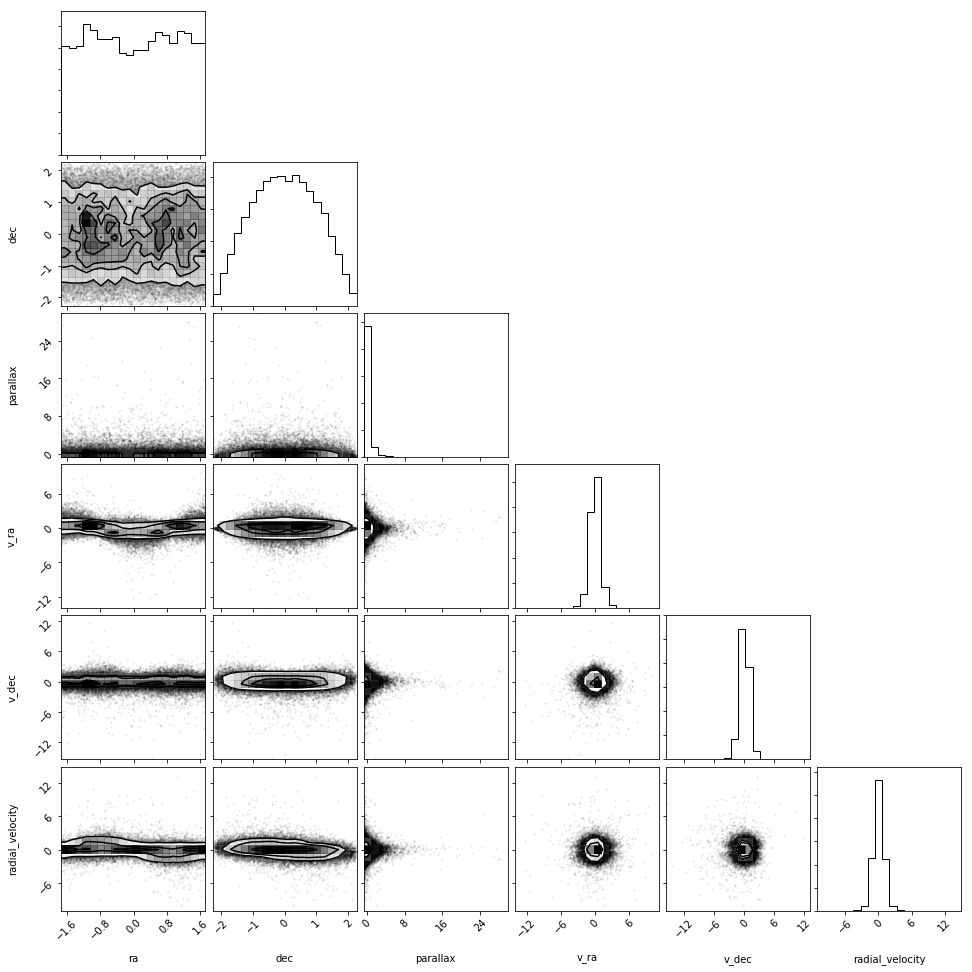

In [22]:
# scaled d1
dscaled = StandardScaler().fit_transform(d1[physical_space])
corner.corner(dscaled, labels=physical_space);

## DBSCAN on the larger dataset

In [23]:
min_samples = 20
eps = 0.3
db = DBSCAN(eps=eps, min_samples=min_samples).fit(dscaled)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 10


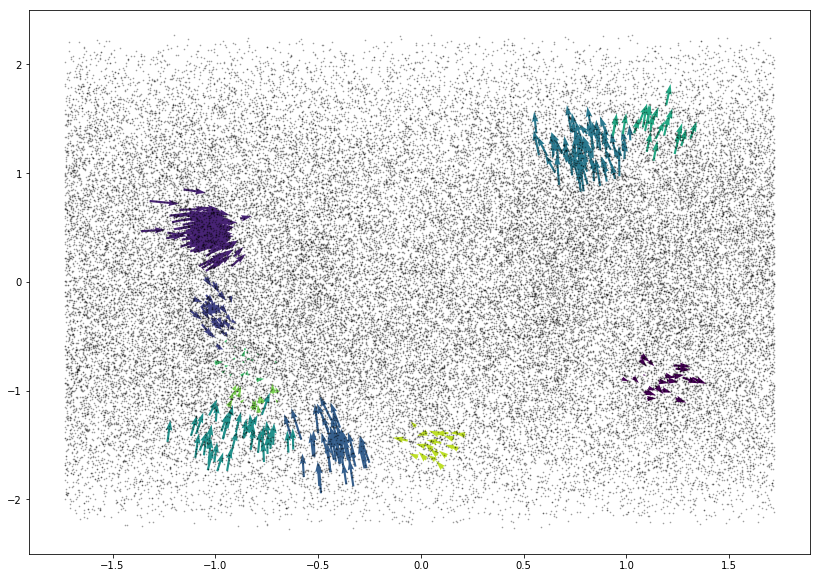

In [24]:
dscaled_clustered = dscaled[labels != -1]

plt.figure(figsize=(14, 10))
plt.quiver(dscaled_clustered[:, 0], dscaled_clustered[:, 1], 
           dscaled_clustered[:, 3], dscaled_clustered[:, 4],
           color=plt.cm.viridis(labels[labels != -1] / 10.))
plt.scatter(dscaled[:, 0][labels == -1], dscaled[:, 1][labels == -1], s=0.5, c='k', alpha=0.3)
plt.show()

## Whoa are these real?

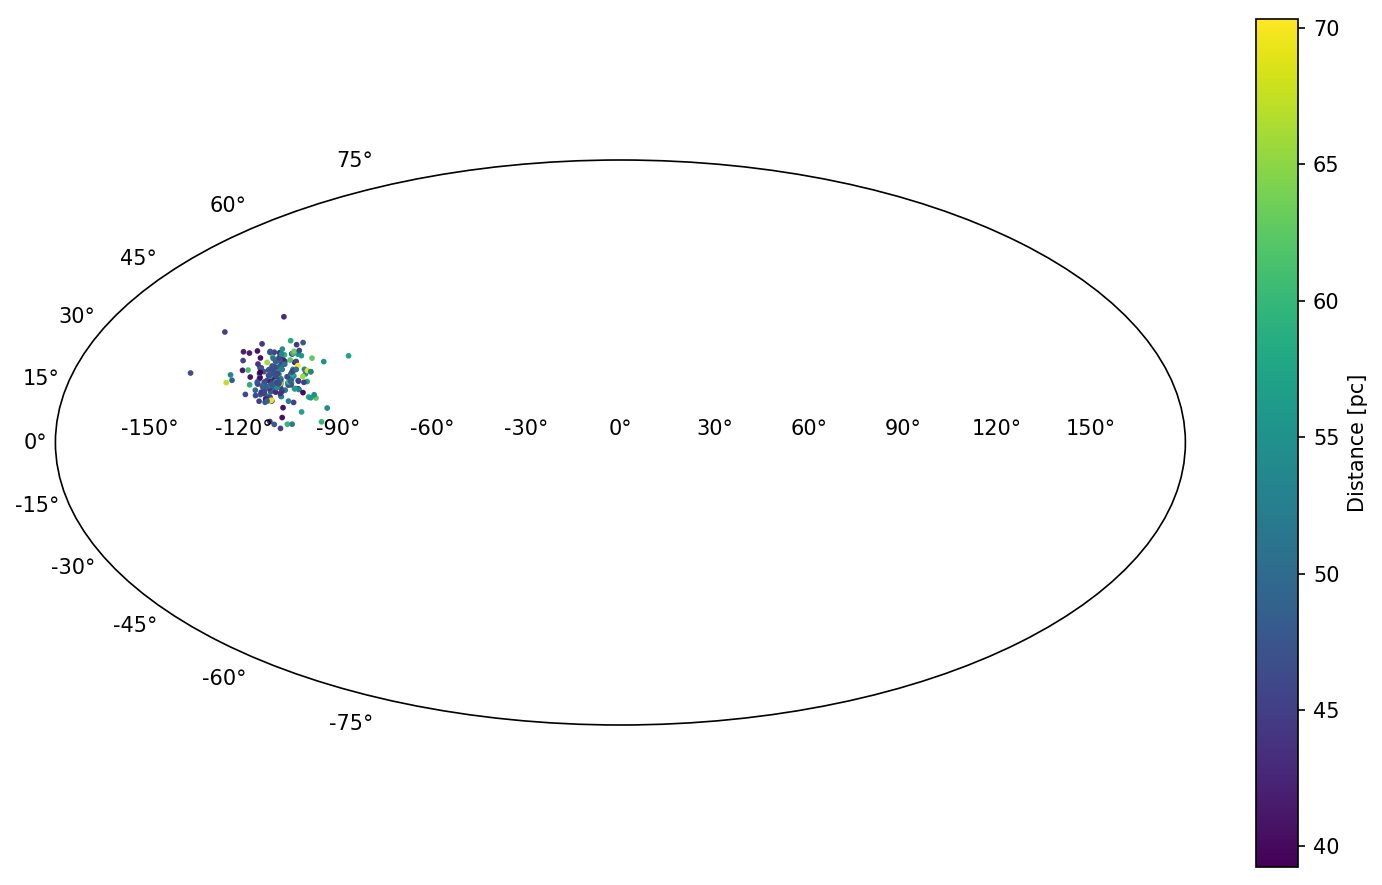

In [25]:
first_cluster = d1[labels == 1]

fig = plt.figure(figsize=(10, 6), dpi=150)
ax = fig.add_subplot(111, projection='mollweide')

im = ax.scatter(np.deg2rad(first_cluster.ra - 180), np.deg2rad(first_cluster.dec), 
                s=3, c=1e3/first_cluster.parallax)
cb = fig.colorbar(im)
cb.set_label('Distance [pc]')
fig.tight_layout()

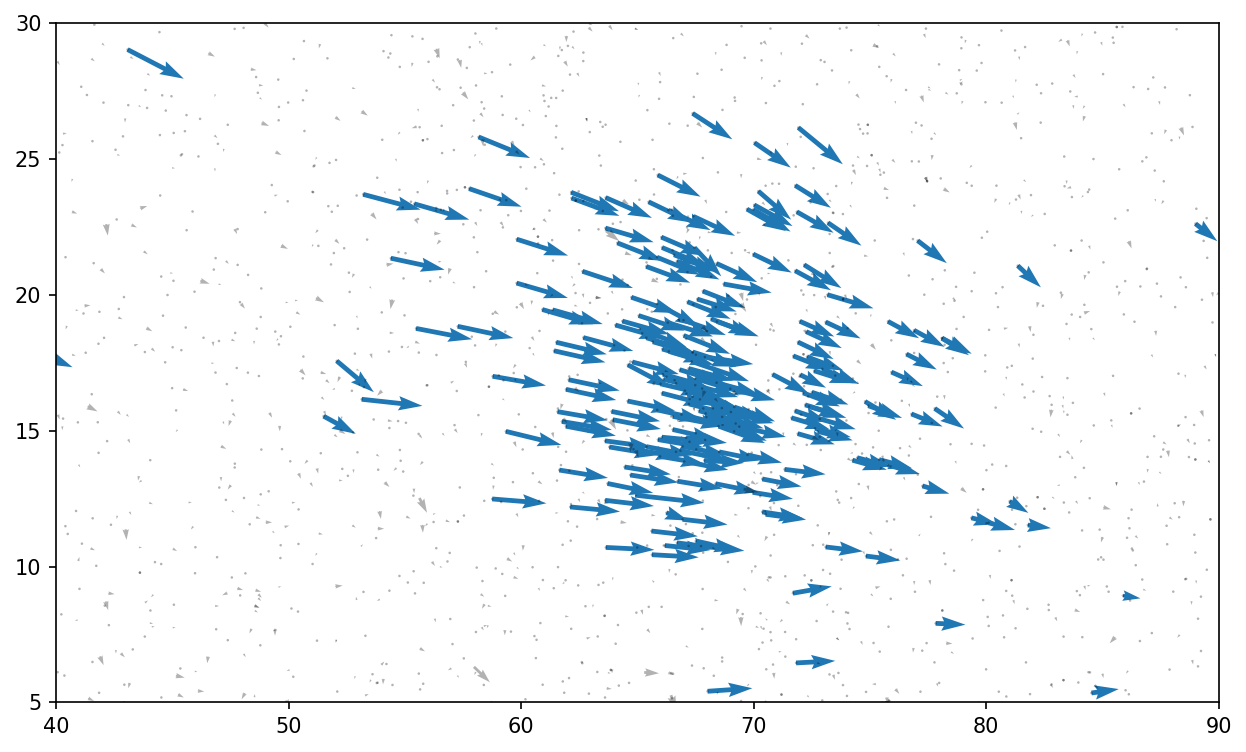

In [26]:
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = fig.add_subplot(111)



ax.quiver(first_cluster.ra, first_cluster.dec, 
          first_cluster.v_ra, first_cluster.v_dec, 
          color='C0')
ax.quiver(d1.ra, d1.dec, d1.v_ra, d1.v_dec, color='k', alpha=0.3)
          
plt.xlim(40, 90)
plt.ylim(5, 30)
plt.show()

## Next step: I probably want to see how these look in Galactocentric coordinates and velocities